# Part-5: Plot a graph of training and validation error with respect todepth of your decision tree.  Also plot the training and validation error with respect to number of nodes in the decision tree

In [1]:
import pandas as pd 
import numpy as np

#for plots
import matplotlib
import matplotlib.pyplot as plt
from pylab import *

import sys #for maxint, minint

In [2]:
class Node(object):
    def __init__(self, root, pos, neg, tf, split):
        self.root = root
        self.pos = pos #no of yes
        self.neg = neg #no of no
        self.children = {} #subtrees
        self.isLeaf = tf #whether a leaf not or not
        self.split = split #where to split for numerical
        if(pos>neg):
            self.result=1 #decision here
        else:
            self.result=0
    def add_child(self, key, val):
        self.children[key]=val

In [3]:
def countYesNo(dataframe): #counts no of positives and negatives at a node
    left_col = dataframe['left']
    pos = dataframe[left_col == 1] 
    
    #no of rows of yes
    yes_r = pos.shape[0]

    neg = dataframe[left_col == 0]
    
    #no of rows of no
    no_r = neg.shape[0]
    
    return yes_r, no_r

In [4]:
#Step-1: Compute impurity score of training label distribution
#entropy of entire dataset, params: dataframe, target- target col
#returns entropy 
def entropyCalculate(dataframe, target):
    total_len=len(dataframe)
    col=dataframe[target]
    s = pd.Series(col) 
    count_arr=s.value_counts() #has no of 0s and 1s
    entropy=0
    for counts in count_arr:
        prob = float(counts)/total_len
        entropy += -1*prob* np.log2(prob)
    
    return entropy

In [5]:
#Step-2: Compute impurity score for each unique value of candidate attributes
#Step-3: Compute impurity score for candidate attribute 
#entropy for each attribute, params: dataframe, coloumnName, target
#returns entropy for sub attributes
def entropyAttribute(dataframe, col_name, label):
    col=dataframe[col_name] 
    
    #total rows in this col, eg sales -8990
    col_len=len(col) 
    
    #convert the column to series
    s = pd.Series(col)
    
    #find all unique attr, eg low,med,high
    unique_val = s.unique() 

    total_entropy=0
    
    for i in unique_val:
        #all rows in the col where sub attribute is i, eg for sales , i=accounting..
        ar = dataframe[col==i]
        
        #find no. of rows for that subattribute
        total_r = ar.shape[0]
        
        #made a dataframe for this attribute
        cur_df = pd.DataFrame(ar) 
        
        #now suppose attribute=sales, value=accounting, find entropy now for accounting
        curr_entropy = entropyCalculate(cur_df, label)
        
        fraction = float(total_r)/col_len
        total_entropy += fraction * curr_entropy
        
    return total_entropy    

In [6]:
#Step-4: Compute Information Gain (reduction in impurity score) provided by candidate attribute
#Step-5: Compare Information Gain provided by all candidates
#params: dataframe, numerical, categorical lists
#returns root and splitPoint (if numerical)

def findMaxInfoGain(dataframe, num, categ):
    unique_cols = dataframe.columns.tolist()
    label = 'left'
    
    entropy = entropyCalculate(dataframe, label)
    max = -sys.maxint - 1
    temp = 0
    attr_entropy=0
    split=0
    for i in unique_cols:
        if i != label:            
            if i in num:
                #this is a numerical attribute
                attr_entropy, idx = findSplit(dataframe, i)
                
            elif i in categ:
                attr_entropy = entropyAttribute(dataframe, i, label)
            
            temp = entropy - attr_entropy
            
            if temp>max:
                max=temp
                root=i
                if i in num:
                    split = idx
                else:
                    split = -1
    return root, split        

In [7]:
#finds split for numerical column, calculates entire entropy and finds the minimum one
#param: dataframe, numerical col
#return: minimum entropy and corresponding split point
def findSplit(dataframe, col):
    label = 'left'
    min = sys.maxint
    idx=0
    for j in pd.Series(dataframe[col]).unique():
        less_than = dataframe[dataframe[col] > j]
        grea_than = dataframe[dataframe[col] <= j]

        less_rows = less_than.shape[0]
        grea_rows = grea_than.shape[0]
        tot = less_rows + grea_rows
        e1 = entropyCalculate(less_than, label)
        e2 = entropyCalculate(grea_than, label)

        entropy = ((e1*less_rows)/tot + (e2*grea_rows)/tot)
        if(min>entropy):
            min = entropy
            idx = j
    return min, idx

In [8]:
#build Tree using entropy
#param: dataframe, numerical, categorical lists
#return: root of the tree- tree_root
def buildTree(dataframe, num, categ): 
    yes, no = countYesNo(dataframe)
    
    if no==0: #node is yes->1
        return Node(1,yes,0,True,-1)
        
    elif yes==0: #node is no->0
        return Node(0,0,no,True,-1)
    
    root_node,split = findMaxInfoGain(dataframe, num, categ) #work_acc
    
    tree_root = Node(root_node, yes, no, False,split)
    
    root_col = dataframe[root_node] #work_acc col
    
    if root_node in num:
        #numerical attribute
        grea_than = dataframe[dataframe[root_node] > split]
        less_than = dataframe[dataframe[root_node] <= split]
        
        less_than_tree = buildTree(less_than, num, categ)
        grea_than_tree = buildTree(grea_than, num, categ)
        
        lname = "less_than_"+(str(split))
        gname = "greater_than"+str(split)
        tree_root.add_child(lname,less_than_tree)
        tree_root.add_child(gname,grea_than_tree)
        
    
    elif root_node in categ:
        s = pd.Series(root_col) 
        unique_val = s.unique() 
        for i in unique_val:
            array = dataframe[root_col == i]

            #dataframe for current unique value
            curr = pd.DataFrame(array)

            #now drop this col
            curr = curr.drop(root_node , 1)

            recursive_root = buildTree(curr, num, categ)

            tree_root.add_child(i,recursive_root)
    
    return tree_root


In [9]:
#a helper traverse function to visualize the tree
def traverse(root):
    if len(root.children)==0:
        print "return root: ",root.root
        return
    
    print "Root: ",root.root
    
    for k,v in root.children.items():
        print "root: ",root.root, "key: ",k
        traverse(v)
# traverse(root)

In [10]:
#finds measures for tp, fp, tn, fn , accuracy,precision, recall
def findMeasures(df, predict_col):
    truePos=0
    trueNeg=0
    falsePos=0
    falseNeg=0
 
    for index, row in df.iterrows():
        
        if row[predict_col]==0 and row["left"]==0:
            trueNeg += 1
            
        elif row[predict_col]==0 and row["left"]==1:
            falseNeg += 1
        
        elif row[predict_col]==1 and row["left"]==1:
            truePos += 1
        elif row[predict_col]==1 and row["left"]==0:
            falsePos += 1
#     print "TP, TN, FP, FN: ", truePos, trueNeg, falsePos, falseNeg
    sumtotal = truePos + trueNeg + falsePos + falseNeg
    accuracy = ((float)(truePos + trueNeg))/sumtotal
   
    return accuracy*100

In [11]:
#prediction function
def predict(row,root,num,categ,default=0):
    
    if(root.isLeaf == True):
        return root.result
   
    col=root.root
    split_at = root.split
    val=row[col]
    less_key = ''
    grea_key = ''
    if col in num:
        for k,v in root.children.items():
            if k[0]=='l':
                less_key = k
            else:
                grea_key = k
            
        if val > split_at:
            return predict(row, root.children[grea_key], num,categ)
        else:
            return predict(row, root.children[less_key], num,categ)

    elif col in categ:
        if val in root.children.keys():
            return predict(row,root.children[val],num,categ)
        else:
            return default

#a helper function for making predictions, adds a new col of name predict_col to store the prediction    
def helper(df,root, predict_col):
    df[predict_col] = df.apply(predict, axis=1, args=(root,numerical,categorical,0))

In [12]:
def countNodesDepth(root, depth):
#     print "root: ",root.root, " depth: ",depth
    num_nodes = 0
    if(root.isLeaf or depth==1 ):
        return 1
   
    for k in root.children.keys():
        num_nodes += countNodesDepth(root.children[k], depth-1)
    return num_nodes+1

def forEachNodeCount(root, depth):
    node_count = []
    for i in range (1, depth+1):
        d = countNodesDepth(root,i)
        node_count.append(d)
    return node_count

def predictDepth(row,root,depth,num,categ,default=0):
    
    if(root.isLeaf == True or depth == 0):
        return root.result   
    col=root.root
    split_at = root.split
    val=row[col]
    less_key = ''
    grea_key = ''
    if col in num:
        for k,v in root.children.items():
            if k[0]=='l': #less than
                less_key = k
            else:
                grea_key = k
            
        if val > split_at:
            return predictDepth(row, root.children[grea_key],depth-1, num,categ)
        else:
            return predictDepth(row, root.children[less_key], depth-1,num,categ)

    elif col in categ:
        if val in root.children.keys():
            return predictDepth(row,root.children[val],depth-1,num,categ)
        else:
            return root.result
    
def helperDepth(df,root,depth,predict_col):
    df[predict_col] = df.apply(predictDepth, axis=1, args=(root,depth,numerical,categorical,0))

def findDepth(root):
    depth = 0
    max_depth = 0
    if(root.isLeaf):
        return 1

    for k in root.children.keys():
        depth = findDepth(root.children[k])
        
        if(depth + 1 > max_depth):
            max_depth = 1 + depth
            
    return max_depth

def forEachDepth(df, root, col_name):
    max_depth = findDepth(root) #finds max depth of tree
    error_ar_depth = [] #stores error at each depth
    for i in range(1, max_depth + 1):     
        helperDepth(df,root,i,col_name)
        error = 100 - findMeasures(df, col_name)
        error_ar_depth.append(error)    
    
    return error_ar_depth, max_depth

In [13]:
def plotGraphs():
    error_depth_x, depth, y_node, error_depth_train = solveEntropy(train, validate, numerical, categorical)

    fig, axes = plt.subplots(1,2,figsize=(10, 10))
    y_depth = range(1,depth+1)
    print "error depth x: ", error_depth_x
    print "error depth train: ", error_depth_train
    print "y depth: ", y_depth
    print "y node: ", y_node
    axes[0].plot(error_depth_x, y_depth, label="validation error")
    axes[0].plot(error_depth_train, y_depth, label="training error")
    axes[1].plot(error_depth_x,y_node, label="validation error")
    axes[1].plot(error_depth_train,y_node, label="training error")

    axes[0].set_title('Error vs Depth')
    axes[0].set_xlabel('Error')
    axes[0].set_ylabel('Depth')
    axes[0].legend(loc='best')
    axes[1].set_xlabel('Error')
    axes[1].set_ylabel('Nodes')
    axes[1].legend(loc='best')
    
    axes[1].set_title('Error vs Nodes')
    fig.savefig("q5.png")

In [14]:
def solveEntropy(df_t, df_v, num, cat):
    root = buildTree(df_t, num, cat)
    helper(df_v,root,'prediction') #prediction for entire

    error_ar_depth, depth = forEachDepth(df_v,root,'predict_validate')
    error_depth_train = forEachDepth(df_t,root,'predict_train')[0]
    nodes = forEachNodeCount(root, depth)
    
    return error_ar_depth, depth, nodes, error_depth_train

error depth x:  [17.571174377224196, 17.52669039145907, 5.516014234875442, 3.113879003558722, 2.669039145907476, 2.580071174377224, 2.268683274021356, 2.090747330960852, 2.313167259786468, 2.090747330960852, 2.179715302491104, 2.135231316725978, 2.22419928825623, 2.268683274021356, 2.313167259786468, 2.491103202846972, 2.535587188612098, 2.535587188612098]
error depth train:  [18.00889877641825, 17.875417130144598, 5.695216907675189, 3.4593993325917722, 2.536151279199103, 1.9688542825361424, 1.5684093437152313, 1.2458286985539502, 0.9121245828698505, 0.7119021134593879, 0.5005561735261495, 0.36707452725249823, 0.18909899888764414, 0.1001112347052242, 0.05561735261400713, 0.011123470522804269, 0.0, 0.0]
y depth:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
y node:  [1, 3, 7, 13, 41, 88, 152, 229, 309, 379, 449, 505, 551, 587, 613, 627, 637, 639]


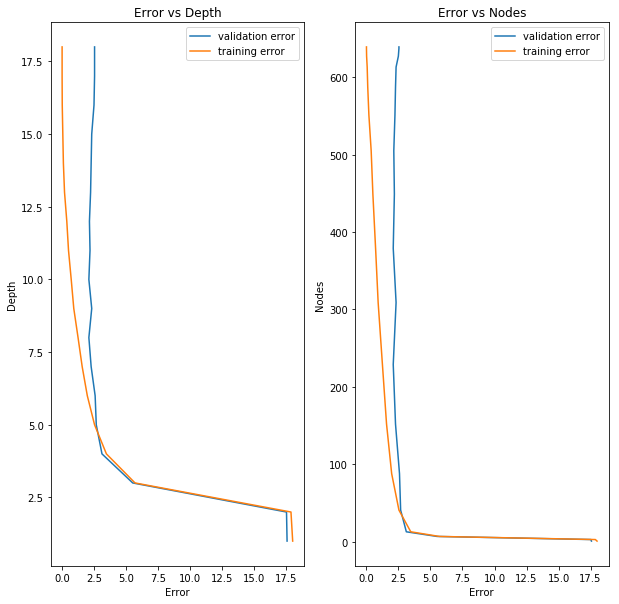

In [15]:
#filename=raw_input('Enter filename: ')
filename = "../input_data/train.csv"

dataset = pd.read_csv(filename)
dataset = dataset.sample(frac=1)

train, validate = np.split(dataset, [int(.8*len(dataset))])

numerical = ['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company']
categorical = ['Work_accident','promotion_last_5years','sales','salary','left']
plotGraphs()